# Basic Idea

<b>We will create a semi-automatic algorithm that will alert to buy or sell in real-time.</br>
This will be done in 4 steps: </b></br>
1) Find 2 assets that move similarly with eachother over the past X periods of time. </br>
2) Calculate the ratio between them.</br>
3) Find the correct signal to buy or sell the assets, by their standard deviation from the mean.</br>
4) Alert buy / sell.

# Basic Concepts
<b>Let's go over some of the concpets we'll use in this project:</b></br>
1) <u>Cointegration:</u> Similar to correlation. Means that the ratio between two series will vary around a mean. </br>  The two series, Y and X follow the follwing: Y = ⍺ X + e where ⍺ is the constant ratio and e is white noise</br>
In plain terms, it means that the ratio between the two financial time series will vary around a constant mean </br>
2) <u>Stationarity:</u> A stochastic process whose unconditional joint probability distribution does not change when shifted in time. (basically - not time dependant). </br>
3) <u>Auto-corelation</u>: Similar to the correlation between two different time series, but autocorrelation uses the same time series twice: once in its original form and once lagged one or more time periods. Auto-correlation is some kind of Stationarity.</br>
4) <u>P-value</u>: The probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. </br> We will use it to test for conitegration. </br>

<u>VECM & VAR</u>: Vector Error Correction Model & Vector Autoregressive.


# Project requirements

In [61]:
from asyncio import threads
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import yfinance as yf
from yahoo_fin.stock_info import get_data
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot

# Data that will be used
We will examine ETFs of tech companies.</br>
Our assumption is that each of them is stationary, and that they will probably be cointegrated, or at least correlated. </br>
We will be looking at the following ETFs: </br>
* VGT
* XLK
* SMH
* SOXX
* IYW 

Which are the Top 5 ETFs considering total assets and 5 years look back window profits. ([etfdb](https://etfdb.com/etfdb-category/technology-equities/))

# Loading data

In [47]:
vgt = yf.Ticker('VGT').history(period='max')
xlk = yf.Ticker('XLK').history(period='max')
smh = yf.Ticker('SMH').history(period='max')
soxx = yf.Ticker('SOXX').history(period='max')
iyw = yf.Ticker('IYW').history(period='max')

# merge all ETFs data frames to one, by Close tag
vgt_xlk = pd.merge(left = vgt[['Close']], right = xlk[['Close']], left_index = True, right_index = True, 
              suffixes = ('_vgt', '_xlk'))
smh_soxx = pd.merge(left = smh[['Close']], right = soxx[['Close']], left_index = True, right_index = True, 
              suffixes = ('_smh', '_soxx'))
combined = pd.merge(left = vgt_xlk, right = smh_soxx, left_index = True, right_index = True)
all = pd.merge(left = iyw[['Close']], right = combined, left_index = True, right_index = True)
all.rename(columns={'Close': 'Close_iyw'}, inplace=True)

all

,Close_iyw,Close_vgt,Close_xlk,Close_smh,Close_soxx
Date,,,,,
2004-01-30,11.002267,42.118591,16.467768,36.527382,55.197609
2004-02-02,10.987015,42.152897,16.467768,36.048595,54.348404
2004-02-03,11.030588,41.895458,16.491024,36.361984,54.569199
2004-02-04,10.677644,40.633953,16.088049,35.326054,52.921757
2004-02-05,10.712505,40.839931,16.111300,35.430523,53.626579
...,...,...,...,...,...
2022-05-02,91.500000,373.269989,143.570007,236.539993,414.160004
2022-05-03,91.620003,373.510010,143.820007,238.479996,417.589996
2022-05-04,94.970001,386.459991,148.869995,246.660004,433.790009


# Ploting Auto-Correlation Functions (ACFs)
We'll see that the ETFs remain centerd even when lagged - which points that they are somewhat stationary.

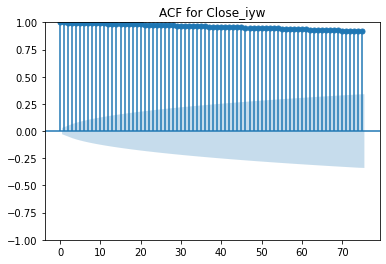

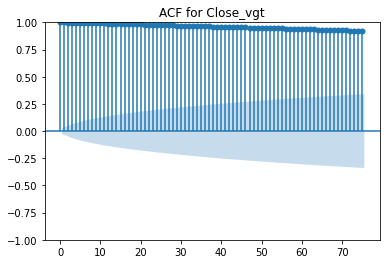

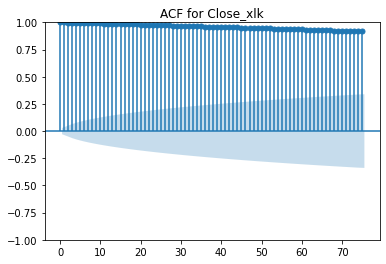

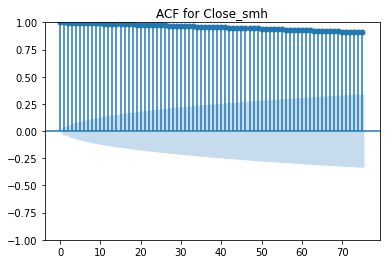

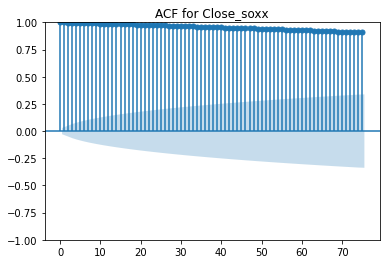

In [44]:
# plots the autocorrelation plots for each stock's closing price at 75 lags
for i in all:
    plot_acf(all[i], lags = 75)
    pyplot.title('ACF for %s' % i) 
    pyplot.show()

# Check for Stationarity
We'll now use Augmented Dickey-Fuller test for Non-Differenced Variables AND for Differenced Variables.
We'll find if the serieses are integrated of order 1 or of order 0.
The null hypothesis is the data are non-stationary, so we want low p-values to tell us our data are stationary.

The results below strongly support the hypothesis that the stocks are integrated I(1). Thus, These stock prices need to be differenced once prior to modeling.

In [51]:
print("========Testing for order 0:")
for i in all:
    for j in ['n', 'c', 'ct']:
        result = adfuller(all[i], regression = j)
        print('ADF Statistic with %s for %s: %f' % (j, i, result[0]))
        print('p-value: %f' % result[1])

print("=============================")
print("========Testing for order 1:")
for i in all:
    for j in ['n', 'c', 'ct']:
        result = adfuller(all[i].diff().dropna(), regression = j)
        print('ADF Statistic with %s for %s: %f' % (j, i, result[0]))
        print('p-value: %f' % result[1])
# stationarity(vgt.history(period='max'))
# stationarity(Asset_2)

========Testing for order 0:
ADF Statistic with n for Close_iyw: 2.934052
p-value: 0.999727
ADF Statistic with c for Close_iyw: 1.614923
p-value: 0.997902
ADF Statistic with ct for Close_iyw: -0.652237
p-value: 0.976105
ADF Statistic with n for Close_vgt: 3.323898
p-value: 0.999972
ADF Statistic with c for Close_vgt: 1.921108
p-value: 0.998561
ADF Statistic with ct for Close_vgt: -0.517062
p-value: 0.982750
ADF Statistic with n for Close_xlk: 3.593011
p-value: 0.999996
ADF Statistic with c for Close_xlk: 2.192962
p-value: 0.998877
ADF Statistic with ct for Close_xlk: -0.288442
p-value: 0.989779
ADF Statistic with n for Close_smh: 2.290177
p-value: 0.996004
ADF Statistic with c for Close_smh: 1.294503
p-value: 0.996578
ADF Statistic with ct for Close_smh: -0.754298
p-value: 0.969325
ADF Statistic with n for Close_soxx: 2.587020
p-value: 0.998668
ADF Statistic with c for Close_soxx: 1.527263
p-value: 0.997622
ADF Statistic with ct for Close_soxx: -0.571419
p-value: 0.980354
========Testi

# Find cointegration
We will use the augmented Engle-Granger two-step cointegration test.</br>
The null hypothesis is that there is no cointegration between the pairs. </br>
Thus, we will be looking for low pvalue. </br>
The threshold we are using is 0.05, which was randomly chosen.

In [59]:
# auxiliary function to find all pairs given a list (nC2)
def n_choose_2(lst):
    pairs_list = []
    for i in range(len(lst) - 1):
        rest = lst[i+1:]
        for j in range(len(rest)):
            pairs_list.append([lst[i], rest[j]])
    return pairs_list
# n_choose_2(all)

In [57]:
def find_cointegrated_pairs(etf_price_list):
    cointegrated_pairs = []
    # filter the ETFs that aren't stationarity
    # etf_price_list = list(filter(lambda a: stationarity(a), etf_price_list))
    # create pairs
    etf_pairs = n_choose_2(etf_price_list)
    print(etf_pairs)
    # for each pair check for cointegration
    for pair in etf_pairs:
        threshold = 0.05  
        coin_result = coint(pair[0], pair[1])
        print(result)
        if result[1] <= threshold:
            cointegrated_pairs.append(pair)
    return cointegrated_pairs
        
# etf_price_list
find_cointegrated_pairs(all)
    

KeyError: 0

# To add, backtesting and correlaiton and more
https://medium.datadriveninvestor.com/creating-and-implementing-a-pairs-trading-strategy-from-scratch-658267bab249